# Interpret Data

Given our models tested and parameters tuned (using GridSearchCV), we can now then look at which model is the best one to choose and finally run the test on the holdout set. First import any libraries and define helper functions:

In [2]:
import os
import warnings
import pickle
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
os.environ['KMP_DUPLICATE_LIB_OK']='True'
warnings.filterwarnings("ignore")
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score, roc_curve, precision_recall_curve, accuracy_score

In [3]:
def bar_chart(x,y,data,title,xlabel,ylabel):
    clrs = ['#D3D3D3' if (item > data[y].min()) else '#FF5A5F' for item in data[y]]
    fig = plt.figure(figsize=(15,10))
    ax=sns.barplot(x=x, y=y, data=data, palette=clrs, ci=None)
    sns.despine()
    sns.set_style("white")
    ax.set_title(title, size=30)
    ax.title.set_position([0.27,1.07])
    ax.set_ylabel(ylabel, rotation='horizontal', fontsize=25);
    ax.yaxis.set_label_coords(-0.05,1.02)
    ax.set_xlabel(xlabel, fontsize=25)
    ax.xaxis.set_label_coords(0.05,-0.05)
    ax.tick_params(labelsize=20)
    for i, v in enumerate(data[y]):
        color=''
        if v > data[y].min():
            color = 'grey'
        else:
            color = 'black'
        ax.text(i,v, str(round(v,4)), color=color, fontweight='bold', fontsize=20, horizontalalignment='center')
    return fig

def plot_roc_curve(fit_model, X_test, y_test, title):
    y_score=fit_model.predict_proba(X_test)[:,1]
    fpr, tpr,_ = roc_curve(y_test, y_score)

    plt.figure(figsize=(6,6))
    # Plotting the Baseline
    plt.plot([0,1],[0,1], '--', color = 'grey')
    plt.plot(fpr,tpr,'m')
    plt.grid(which='major')
    plt.title(f"{title}")
    s= 'AUC: ' + str(round(roc_auc_score(y_test, fit_model.predict(X_test)),3))
    plt.text(0.75, 0.25, s=s, ha='right', va='bottom', fontsize=14,
             bbox=dict(facecolor='grey', alpha=0.5))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate');
    
def plot_PR_curve(fit_model, X_test, y_test, title):
    y_score=fit_model.predict_proba(X_test)[:,1]
    precision, recall, threshold = precision_recall_curve(y_test, y_score)

    plt.figure(figsize=(6,6))
    # Plotting the Baseline
#     plt.plot([0,1],[0,1], '--', color = 'grey')
    plt.plot(recall,precision,'m')
    plt.grid(which='major')
    plt.title(f"{title}")
#     s= 'AUC: ' + str(round(roc_auc_score(y_test, fit_model.predict(X_test)),3))
#     plt.text(0.75, 0.25, s=s, ha='right', va='bottom', fontsize=14,
#              bbox=dict(facecolor='grey', alpha=0.5))
    plt.xlabel('Recall')
    plt.ylabel('Precision');
    return threshold
    
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=18):
    
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names, )
    fig = plt.figure(figsize=figsize)
    try:
        ax=heatmap = sns.heatmap(df_cm, annot=True,annot_kws={"size": 20}, fmt="d",linewidths=.5, cmap=sns.light_palette((1.00000, 0.35294, 0.37255), input="rgb"))
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='center', fontsize=fontsize)
    heatmap.tick_params(length=0)
    ax.set_title('Test Data has AUC-ROC of 0.71', fontsize=30)
    ax.set_xlabel('Predictions', fontsize=25)
    ax.set_ylabel('Actual Rating', rotation='horizontal', fontsize=25)
    ax.title.set_position([.5,5])
    ax.yaxis.set_label_coords(-0.175,0.95)
    ax.xaxis.set_label_coords(0.132,-0.07)

    return fig

def test_prediction(X_test,y_test,model):
    y_pred = model.predict(X_test)
    print(roc_auc_score(y_test, y_pred))
    confusion = confusion_matrix(y_test, y_pred)
    
    return print_confusion_matrix(confusion, ['Not 5-Stars','5-Stars'], figsize = (10,7), fontsize=18)

## Load the Data

In [4]:
data = pickle.load(open("../data/processed/data_EDA_v1_select_amenities.pickle","rb"))

In [5]:
models = pickle.load(open("../results/records/model_history_v1_select_amenities.pkl","rb"))

## Models score comparison

First we look at the ROC-AUC metric and compare them between models:

In [216]:
models = models.sort_values(by="test_metric",ascending=False).reset_index(drop=True)

In [217]:
models.notes = models.notes.str.replace("Best ","").str.replace("using CV","").str.replace(" model ","");
models.notes = models.notes.str.replace("Adaptive Boosting","Adaboost").str.replace("Random Forest","RF").str.replace("Logistic Regression","LR")
models.notes = models.notes.str.replace("SVM ","SVM")#.str.replace("Grad. Boost", "GBoost").str.replace("XG Boost","XG")


In [159]:
models["notes"].iloc[6]='DT'

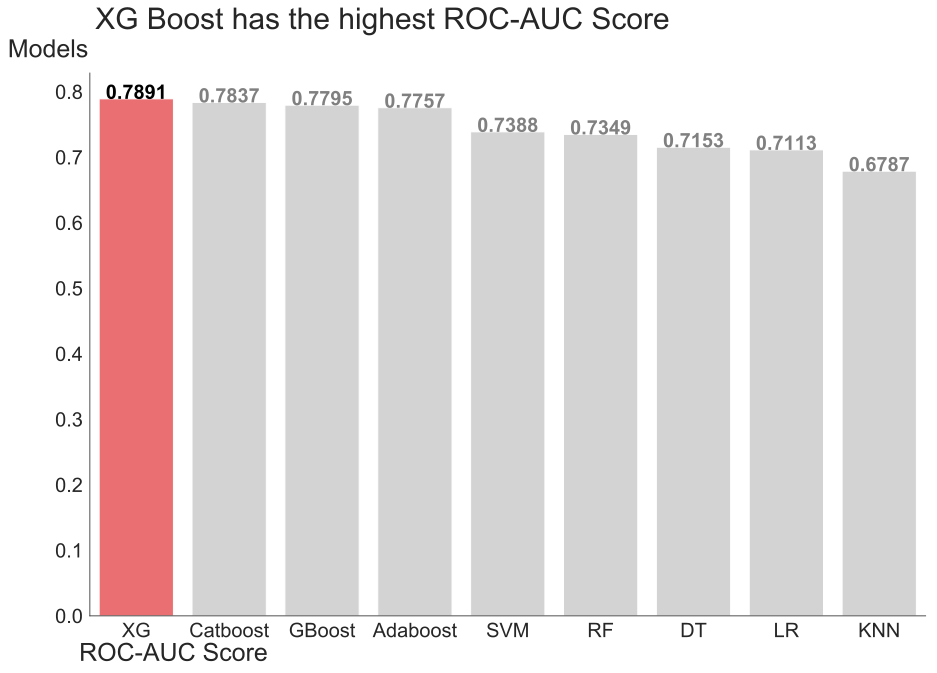

In [204]:
fig_time = bar_chart('notes','test_metric', models,"XG Boost has the highest ROC-AUC Score","ROC-AUC Score","Models")
fig.savefig("../reports/figures/AUCbar.png", dpi=400,bbox_inches='tight')


Now I want to look at how they perform in training/test time:

In [160]:
times=[]
for i in models.model:
    start = time.time()
    i.fit(X_train,y_train)
    end = time.time()
    times.append(end-start)

0:	learn: 0.6792478	total: 49.1ms	remaining: 14.7s
1:	learn: 0.6648103	total: 97.9ms	remaining: 14.6s
2:	learn: 0.6525887	total: 150ms	remaining: 14.9s
3:	learn: 0.6420216	total: 194ms	remaining: 14.3s
4:	learn: 0.6352228	total: 237ms	remaining: 14s
5:	learn: 0.6283160	total: 288ms	remaining: 14.1s
6:	learn: 0.6224405	total: 330ms	remaining: 13.8s
7:	learn: 0.6156447	total: 372ms	remaining: 13.6s
8:	learn: 0.6103338	total: 414ms	remaining: 13.4s
9:	learn: 0.6065443	total: 439ms	remaining: 12.7s
10:	learn: 0.6021752	total: 480ms	remaining: 12.6s
11:	learn: 0.5975370	total: 529ms	remaining: 12.7s
12:	learn: 0.5929152	total: 572ms	remaining: 12.6s
13:	learn: 0.5887117	total: 617ms	remaining: 12.6s
14:	learn: 0.5857251	total: 663ms	remaining: 12.6s
15:	learn: 0.5818148	total: 707ms	remaining: 12.6s
16:	learn: 0.5787266	total: 764ms	remaining: 12.7s
17:	learn: 0.5758876	total: 807ms	remaining: 12.6s
18:	learn: 0.5735368	total: 868ms	remaining: 12.8s
19:	learn: 0.5713515	total: 911ms	remaini

162:	learn: 0.4293004	total: 8.65s	remaining: 7.28s
163:	learn: 0.4283702	total: 8.72s	remaining: 7.24s
164:	learn: 0.4278487	total: 8.8s	remaining: 7.2s
165:	learn: 0.4273204	total: 8.87s	remaining: 7.16s
166:	learn: 0.4261887	total: 8.94s	remaining: 7.12s
167:	learn: 0.4252022	total: 8.99s	remaining: 7.06s
168:	learn: 0.4248038	total: 9.04s	remaining: 7.01s
169:	learn: 0.4243638	total: 9.11s	remaining: 6.96s
170:	learn: 0.4242367	total: 9.16s	remaining: 6.91s
171:	learn: 0.4227627	total: 9.24s	remaining: 6.88s
172:	learn: 0.4224098	total: 9.32s	remaining: 6.84s
173:	learn: 0.4219806	total: 9.41s	remaining: 6.82s
174:	learn: 0.4214003	total: 9.49s	remaining: 6.78s
175:	learn: 0.4207776	total: 9.57s	remaining: 6.74s
176:	learn: 0.4198286	total: 9.62s	remaining: 6.68s
177:	learn: 0.4193279	total: 9.66s	remaining: 6.62s
178:	learn: 0.4184324	total: 9.71s	remaining: 6.56s
179:	learn: 0.4175075	total: 9.75s	remaining: 6.5s
180:	learn: 0.4173560	total: 9.8s	remaining: 6.44s
181:	learn: 0.41

In [161]:
test_times=[]
for i in models.model:
    start = time.time()
    i.predict(X_test)
    end = time.time()
    test_times.append(end-start)

In [218]:
models["train_time"] = times
models["test_time"] = test_times

In [219]:
models

,model,hyperparameters,target,features,observations,metric,test_metric,notes,train_time,test_time
0,"XGBClassifier(base_score=0.5, booster='gbtree'...","{'colsample_bytree': 0.6, 'gamma': 0.1, 'max_d...",fivestars,56,5632,AUC ROC,0.789146,XG Boost,6.848296,0.034892
1,<catboost.core.CatBoostClassifier object at 0x...,"{'depth': 7, 'iterations': 300, 'l2_leaf_reg':...",fivestars,56,5632,AUC ROC,0.783730,Catboost,15.697420,0.015883
2,([DecisionTreeRegressor(criterion='friedman_ms...,"{'criterion': 'friedman_mse', 'learning_rate':...",fivestars,56,5632,AUC ROC,0.779490,Grad. Boost,0.816819,0.002792
3,"(DecisionTreeClassifier(class_weight=None, cri...","{'algorithm': 'SAMME.R', 'learning_rate': 0.35...",fivestars,56,5632,AUC ROC,0.775651,Adaboost,2.391568,0.072425
4,"SVC(C=1.6681005372000592, cache_size=200, clas...","{'C': 1.6681005372000592, 'degree': 2, 'kernel...",fivestars,56,5632,AUC ROC,0.738789,SVM,10.357127,0.362258
5,"(DecisionTreeClassifier(class_weight=None, cri...","{'criterion': 'gini', 'max_depth': 3, 'n_estim...",fivestars,56,5632,AUC ROC,0.734882,RF,0.091826,0.006862
6,"DecisionTreeClassifier(class_weight=None, crit...","{'criterion': 'gini', 'max_depth': 5}",fivestars,56,5632,AUC ROC,0.715313,LR,0.021089,0.000746
7,"LogisticRegression(C=0.03556480306223129, clas...",{'C': 0.03556480306223129},fivestars,56,5632,AUC ROC,0.711295,LR,0.058440,0.000639
8,"KNeighborsClassifier(algorithm='auto', leaf_si...",{'n_neighbors': 165},fivestars,56,5632,AUC ROC,0.678734,KNN,0.029103,0.814927


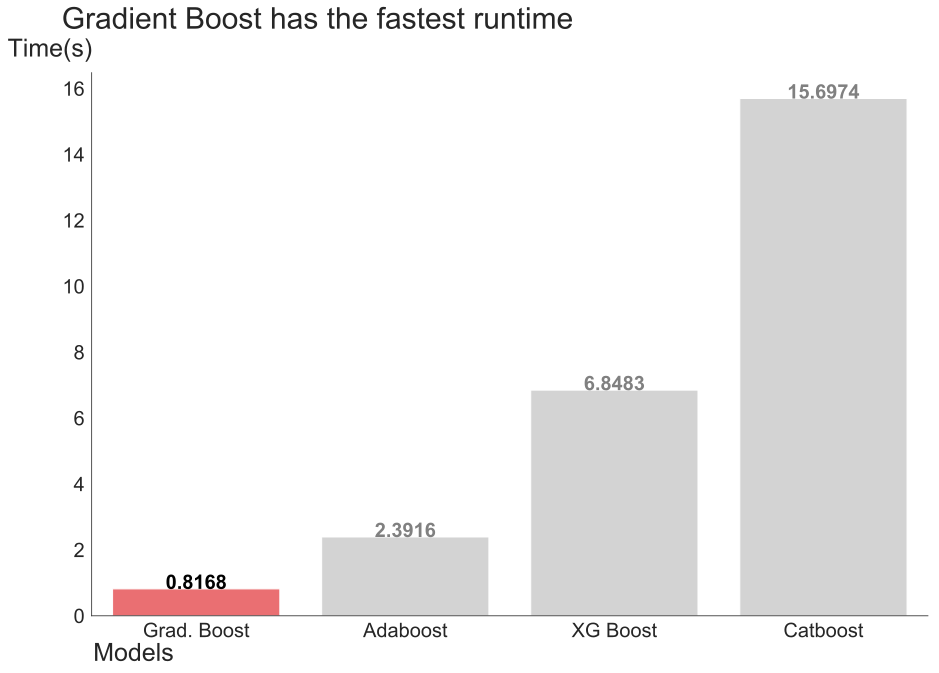

In [229]:
models = models.sort_values(by="train_time").reset_index(drop=True)
fig_time = bar_chart('notes',"train_time",models[(models.notes.str.contains("Boost")) | (models.notes.str.contains("boost"))],"Gradient Boost has the fastest runtime","Models","Time(s)")
fig_time.savefig("../reports/figures/timebar.png", dpi=400,bbox_inches='tight')

## Test on the Holdout (Test) Set

In [19]:
y = data['fivestars']
X = pd.get_dummies(data.drop('fivestars',axis=1))
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X)
scaled_data = pd.DataFrame(scaled_data, columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(scaled_data, y, test_size=0.2, random_state=42)







In [23]:
xg = models[models.notes =="XG Boost"]["model"][0]

In [25]:
xg.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0.1, learning_rate=0.02,
       max_delta_step=0, max_depth=3, min_child_weight=3, missing=nan,
       n_estimators=600, n_jobs=1, nthread=1, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.4)

0.7055703211517166


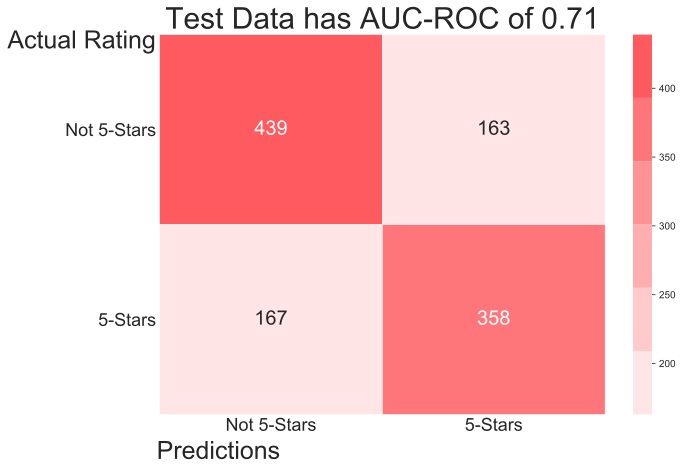

In [243]:
confuse=test_prediction(X_test,y_test,xg);

In [241]:
confuse.savefig("../reports/figures/confusion.png", dpi=400, bbox_inches='tight')

In [6]:
data.columns

Index(['host_since', 'host_response_time', 'host_response_rate',
       'host_total_listings_count', 'host_verifications',
       'host_identity_verified', 'neighbourhood_group_cleansed', 'room_type',
       'bathrooms', 'bedrooms', 'beds', 'price', 'security_deposit',
       'cleaning_fee', 'extra_people', 'minimum_nights', 'calendar_updated',
       'availability_30', 'availability_90', 'cancellation_policy',
       'reviews_per_month', 'number_of_reviews', 'number_of_reviews_ltm',
       'instant_bookable', 'bikescore', 'walkscore', 'price_bed',
       '24-hour check-in', 'Air conditioning', 'BBQ grill', 'Bed linens',
       'Cable TV', 'Coffee maker', 'Dishwasher', 'Elevator',
       'Extra pillows and blankets', 'Family/kid friendly',
       'Fire extinguisher', 'First aid kit', 'Gym', 'Indoor fireplace',
       'Internet', 'Keypad', 'Lock on bedroom door', 'Lockbox',
       'Long term stays allowed', 'Luggage dropoff allowed',
       'Pack ’n Play/travel crib', 'Patio or balcony'